In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('datasets/diabetes.csv')

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.shape

(768, 9)

In [6]:
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [3]:
# Imbalanced Data
df.Outcome.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [7]:
# separate features & outcomes
x = df.drop(columns=['Outcome'])
y = df['Outcome']

In [10]:
# Build a pipeline function to make pre-processing easier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_absolute_error,mean_squared_error
import joblib

def data_split_standardise(x,y=None):
    if y is None:
        st=StandardScaler()
        st.fit(x)
        x_std=st.transform(x)
        joblib.dump(st,"StandardScalar_trained.h5")
        return(x_std)
    else:

        
        
        
        x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)
        st=StandardScaler()
        st.fit(x_train)
        x_train_std=st.transform(x_train)
        x_test_std=st.transform(x_test)
        joblib.dump(st,"StandardScalar_trained.h5")    
        return(x_train_std,x_test_std,y_train,y_test)

In [11]:
x_train_std, x_test_std, y_train, y_test = data_split_standardise(x,y)

In [12]:
# Build Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

2023-02-18 08:31:13.577413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
model = Sequential()
model.add(Input(shape=(None,x_train_std.shape[1]),name='Input_Layer'))
model.add(Dense(12,activation='relu',name='Hidden_Layer_1'))
model.add(Dense(14,activation='relu',name='Hidden_Layer_2'))
model.add(Dense(1,activation='sigmoid',name='Output_Layer')) # Sigmoid good for binary classification

In [ ]:
from tensorflow.keras.metrics import Precision, Recall # do report metrics in the livelossplot

In [29]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',Precision(),Recall()])

In [16]:
from livelossplot import PlotLossesKerasTF

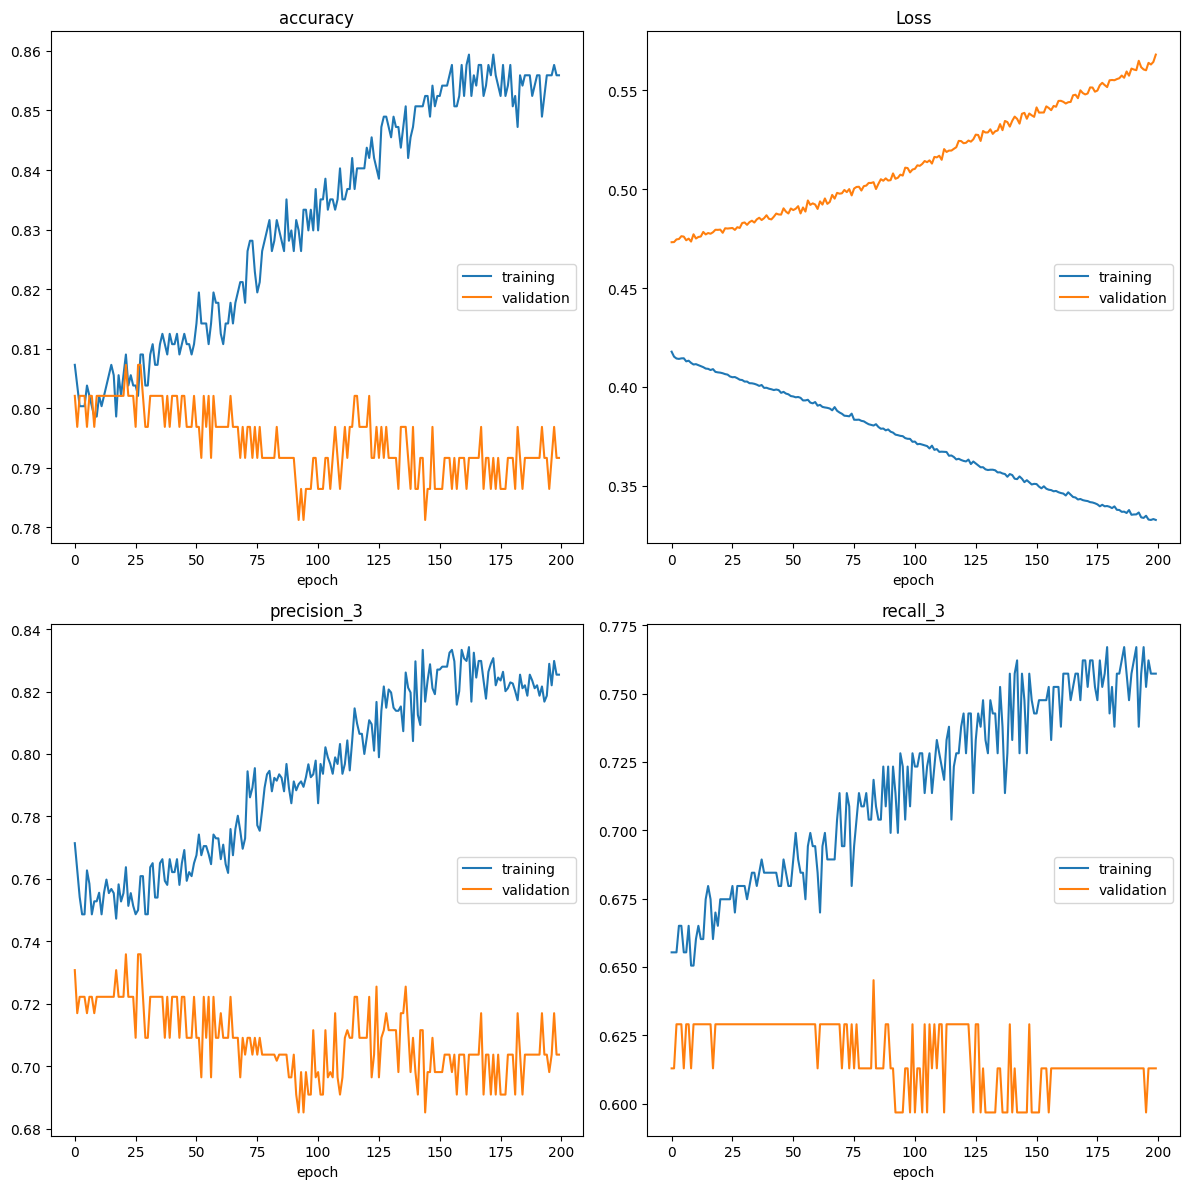

accuracy
	training         	 (min:    0.799, max:    0.859, cur:    0.856)
	validation       	 (min:    0.781, max:    0.807, cur:    0.792)
Loss
	training         	 (min:    0.333, max:    0.418, cur:    0.333)
	validation       	 (min:    0.473, max:    0.568, cur:    0.568)
precision_3
	training         	 (min:    0.747, max:    0.834, cur:    0.825)
	validation       	 (min:    0.685, max:    0.736, cur:    0.704)
recall_3
	training         	 (min:    0.650, max:    0.767, cur:    0.757)
	validation       	 (min:    0.597, max:    0.645, cur:    0.613)
18/18 [==============================] - 1s 68ms/step - loss: 0.3328 - accuracy: 0.8559 - precision_3: 0.8254 - recall_3: 0.7573 - val_loss: 0.5680 - val_accuracy: 0.7917 - val_precision_3: 0.7037 - val_recall_3: 0.6129


In [30]:
model.fit(x_train_std,y_train,epochs=200,validation_data=(x_test_std,y_test),callbacks=[PlotLossesKerasTF()])

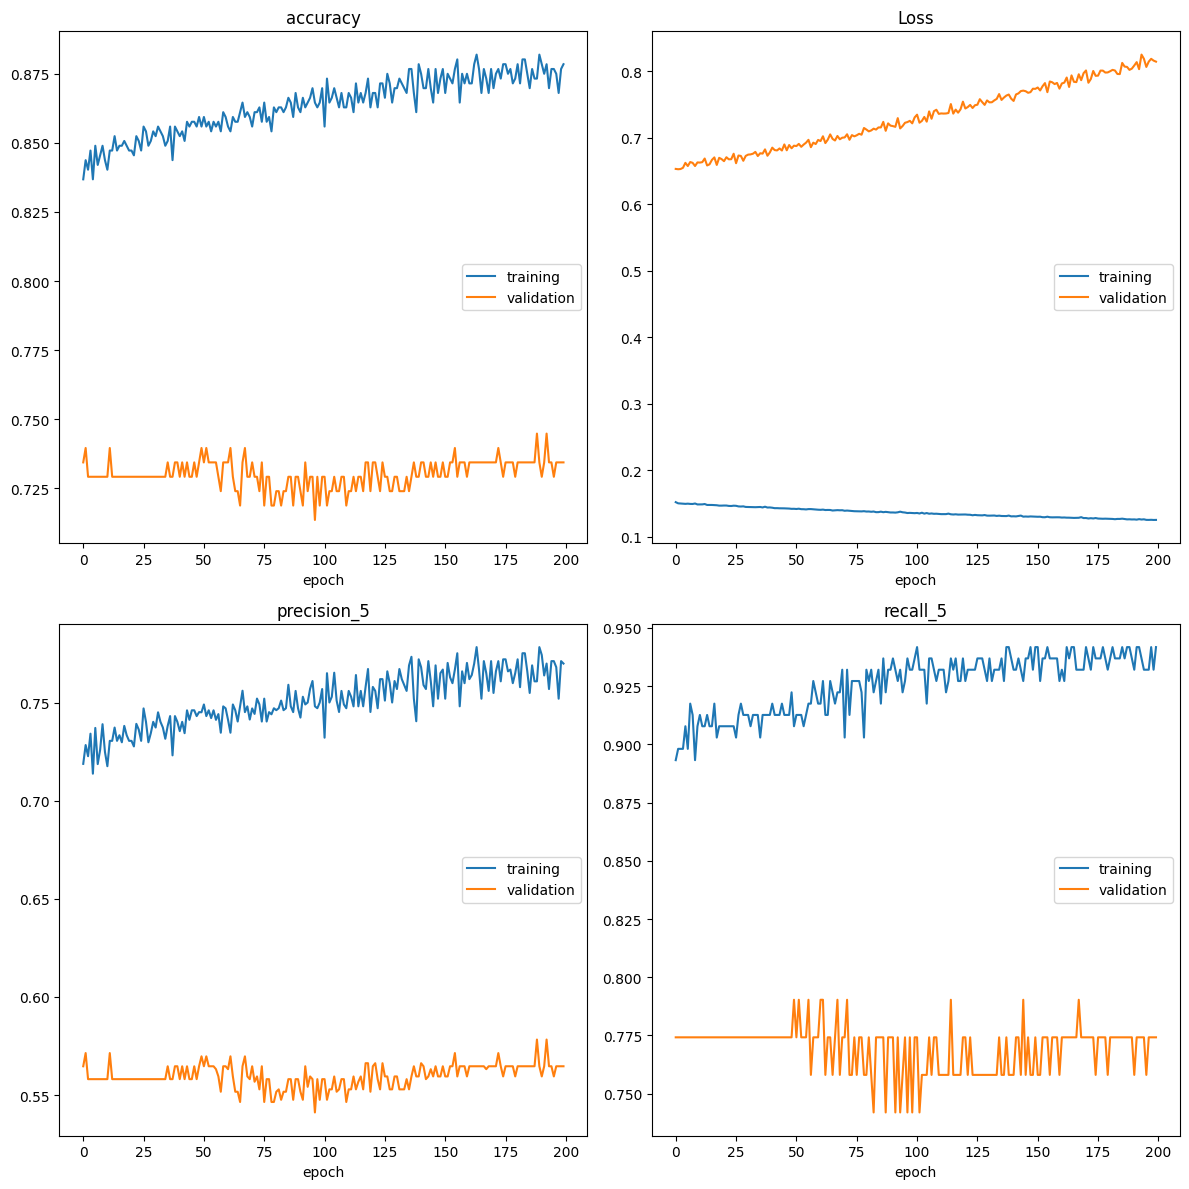

accuracy
	training         	 (min:    0.837, max:    0.882, cur:    0.878)
	validation       	 (min:    0.714, max:    0.745, cur:    0.734)
Loss
	training         	 (min:    0.125, max:    0.152, cur:    0.125)
	validation       	 (min:    0.653, max:    0.825, cur:    0.814)
precision_5
	training         	 (min:    0.714, max:    0.778, cur:    0.770)
	validation       	 (min:    0.541, max:    0.578, cur:    0.565)
recall_5
	training         	 (min:    0.893, max:    0.942, cur:    0.942)
	validation       	 (min:    0.742, max:    0.790, cur:    0.774)
18/18 [==============================] - 1s 57ms/step - loss: 0.1254 - accuracy: 0.8785 - precision_5: 0.7698 - recall_5: 0.9417 - val_loss: 0.8143 - val_accuracy: 0.7344 - val_precision_5: 0.5647 - val_recall_5: 0.7742


In [33]:
# This model is overfitted
# It's because of the weights of our classes - they're imbalanced
# Add the class_weight hyperparameter while fitting

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',Precision(),Recall()])

model.fit(
    x_train_std,
    y_train,
    epochs=200,
    validation_data=(x_test_std,y_test),
    callbacks=[PlotLossesKerasTF()],
    class_weight={1:0.8, 0:0.3}
)

# Overfitting

## Regularization

In [45]:
# The model is still overfitted... How do we handle that?

# Regularization - Introduce penalty term for nodes that get too heavy
# We typically use an L2 regularization penalty term (much like Ridge Regression)

from tensorflow.keras.regularizers import L2, L1

In [42]:
model2 = Sequential()
model2.add(Input(shape=(None,x_train_std.shape[1]),name='Input_Layer'))
model2.add(Dense(12,activation='relu',name='Hidden_Layer_1',kernel_regularizer=L2(l2=0.01))) # add regularizer to hidden layers
model2.add(Dense(14,activation='relu',name='Hidden_Layer_2',kernel_regularizer=L2(l2=0.01)))
model2.add(Dense(1,activation='sigmoid',name='Output_Layer'))

In [43]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, None, 12)          108       
                                                                 
 Hidden_Layer_2 (Dense)      (None, None, 14)          182       
                                                                 
 Output_Layer (Dense)        (None, None, 1)           15        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


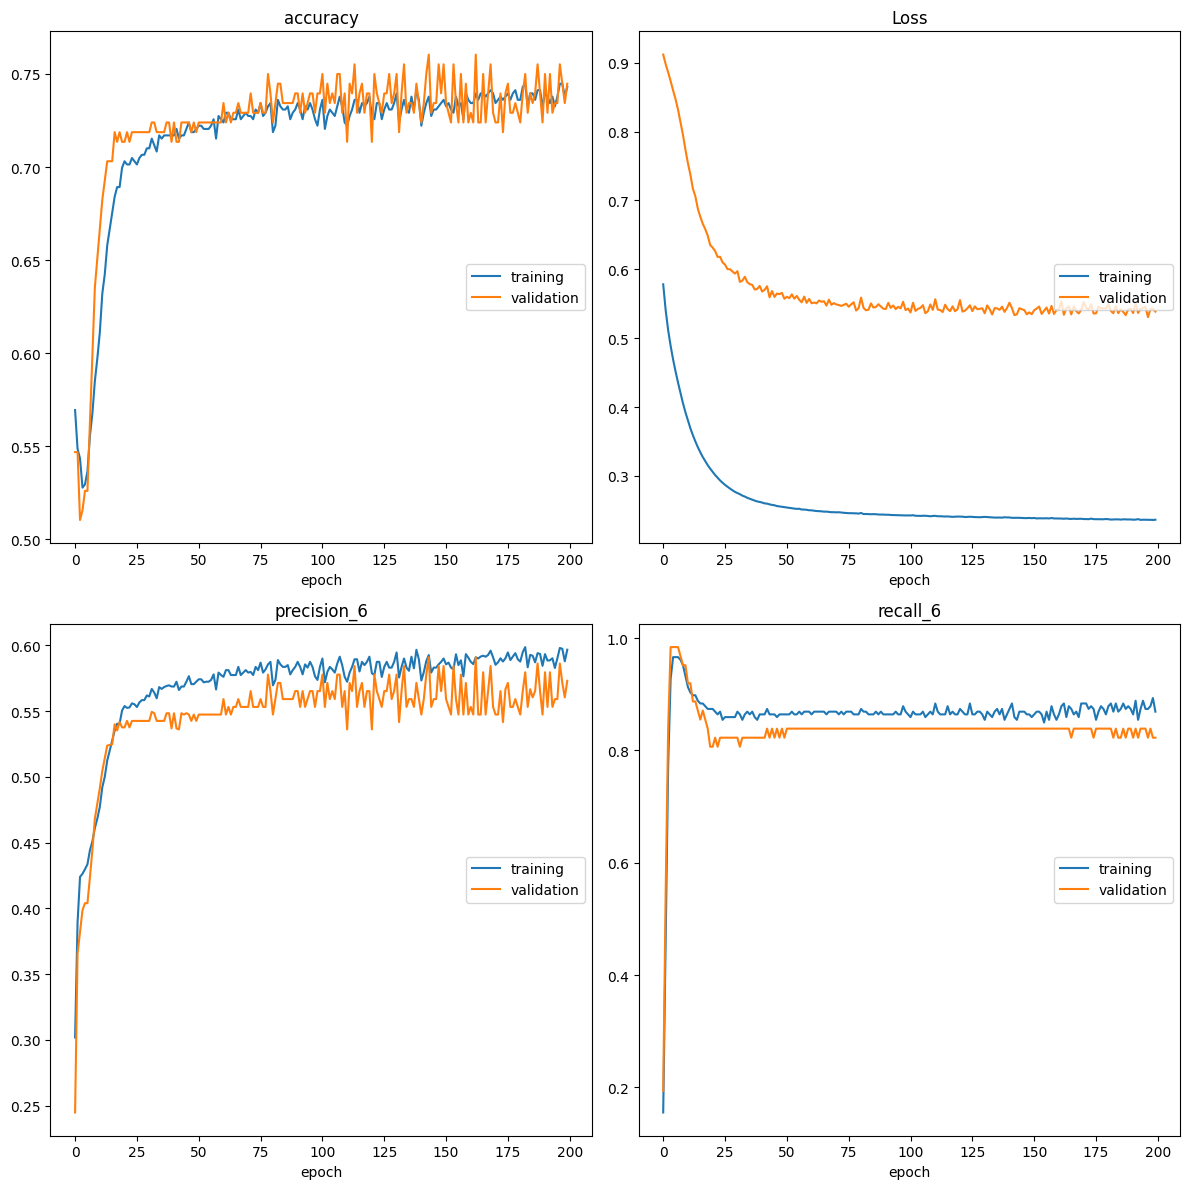

accuracy
	training         	 (min:    0.528, max:    0.745, cur:    0.743)
	validation       	 (min:    0.510, max:    0.760, cur:    0.745)
Loss
	training         	 (min:    0.236, max:    0.578, cur:    0.236)
	validation       	 (min:    0.531, max:    0.912, cur:    0.539)
precision_6
	training         	 (min:    0.302, max:    0.599, cur:    0.597)
	validation       	 (min:    0.245, max:    0.591, cur:    0.573)
recall_6
	training         	 (min:    0.155, max:    0.966, cur:    0.869)
	validation       	 (min:    0.194, max:    0.984, cur:    0.823)
18/18 [==============================] - 1s 48ms/step - loss: 0.2363 - accuracy: 0.7431 - precision_6: 0.5967 - recall_6: 0.8689 - val_loss: 0.5385 - val_accuracy: 0.7448 - val_precision_6: 0.5730 - val_recall_6: 0.8226


In [44]:
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',Precision(),Recall()])

model2.fit(
    x_train_std,
    y_train,
    epochs=200,
    validation_data=(x_test_std,y_test),
    callbacks=[PlotLossesKerasTF()],
    class_weight={1:0.8, 0:0.3}
)

# Much better accuracy, precision, recall after regularization

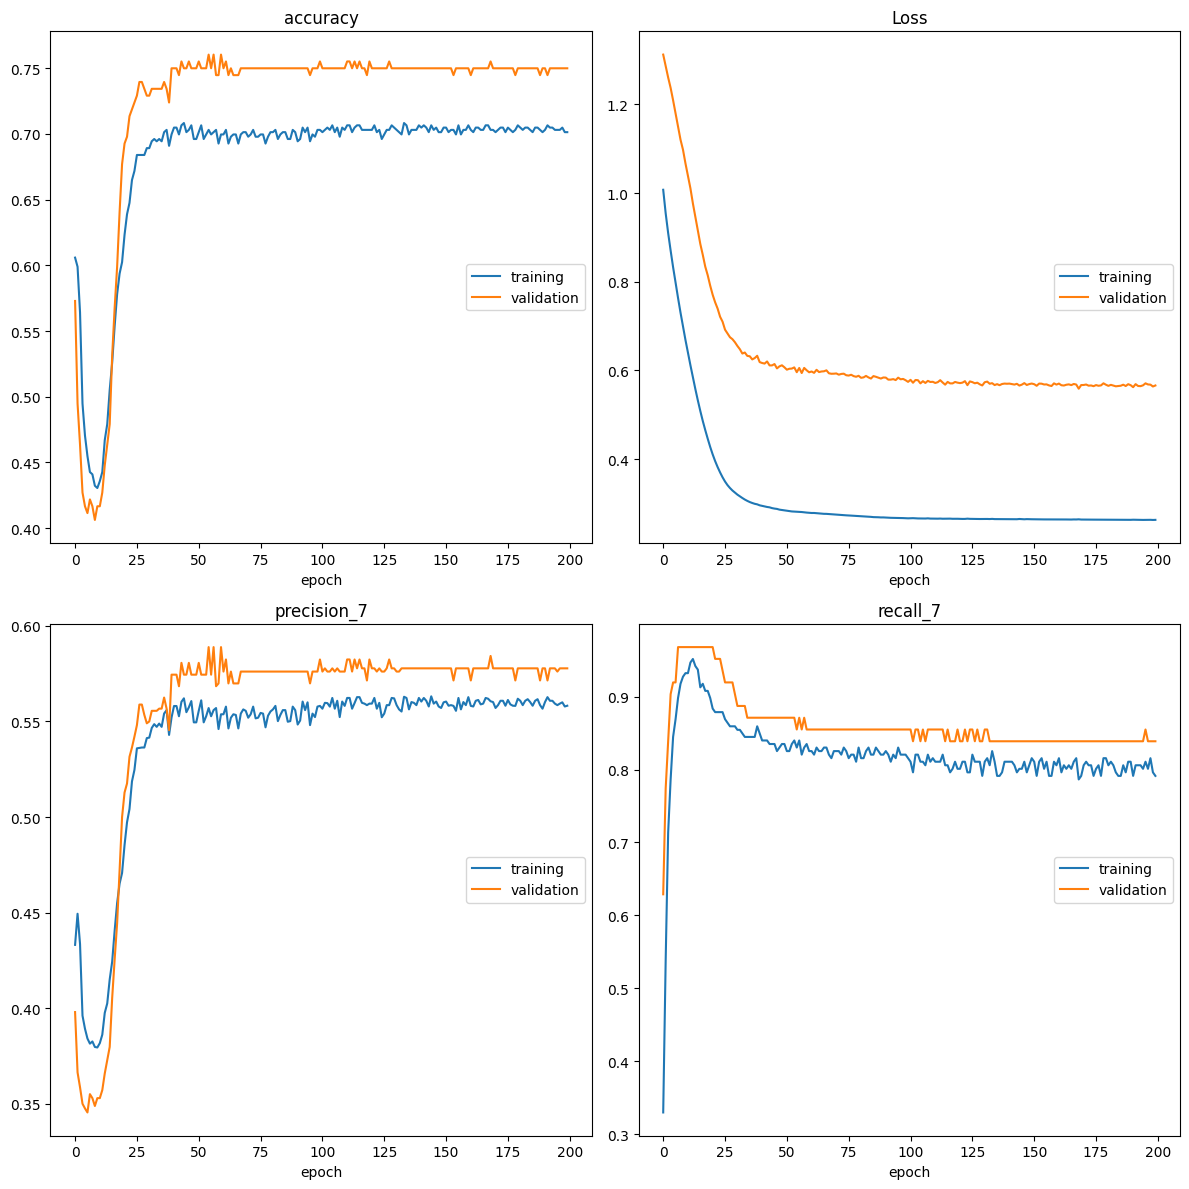

accuracy
	training         	 (min:    0.431, max:    0.708, cur:    0.701)
	validation       	 (min:    0.406, max:    0.760, cur:    0.750)
Loss
	training         	 (min:    0.263, max:    1.007, cur:    0.263)
	validation       	 (min:    0.559, max:    1.312, cur:    0.566)
precision_7
	training         	 (min:    0.379, max:    0.563, cur:    0.558)
	validation       	 (min:    0.345, max:    0.589, cur:    0.578)
recall_7
	training         	 (min:    0.330, max:    0.951, cur:    0.791)
	validation       	 (min:    0.629, max:    0.968, cur:    0.839)
18/18 [==============================] - 1s 49ms/step - loss: 0.2632 - accuracy: 0.7014 - precision_7: 0.5582 - recall_7: 0.7913 - val_loss: 0.5662 - val_accuracy: 0.7500 - val_precision_7: 0.5778 - val_recall_7: 0.8387


In [46]:
#Attempt with L1 Regularization
model3 = Sequential()
model3.add(Input(shape=(None,x_train_std.shape[1]),name='Input_Layer'))
model3.add(Dense(12,activation='relu',name='Hidden_Layer_1',kernel_regularizer=L1(l1=0.01))) # Use L1 Regularizer this time
model3.add(Dense(14,activation='relu',name='Hidden_Layer_2',kernel_regularizer=L1(l1=0.01)))
model3.add(Dense(1,activation='sigmoid',name='Output_Layer'))

model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',Precision(),Recall()])

model3.fit(
    x_train_std,
    y_train,
    epochs=200,
    validation_data=(x_test_std,y_test),
    callbacks=[PlotLossesKerasTF()],
    class_weight={1:0.8, 0:0.3}
)

#Also performs pretty well

## Dropout

In [47]:
# We can also try to solve the overfitting problem by randomly removing nodes from hidden layers to
# identify nodes that are too heavy 
# --> dropping a heavy node will drastically change the weights of other nodes in that training run

from tensorflow.keras.layers import Dropout

In [48]:
model4 = Sequential()
model4.add(Input(shape=(None,x_train_std.shape[1]),name='Input_Layer'))
model4.add(Dense(12,activation='relu',name='Hidden_Layer_1'))
model4.add(Dropout(0.30)) # Add a Dropout Layer
model4.add(Dense(14,activation='relu',name='Hidden_Layer_2'))
model4.add(Dropout(0.30)) # Add a Dropout Layer
model4.add(Dense(1,activation='sigmoid',name='Output_Layer'))

In [49]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, None, 12)          108       
                                                                 
 dropout (Dropout)           (None, None, 12)          0         
                                                                 
 Hidden_Layer_2 (Dense)      (None, None, 14)          182       
                                                                 
 dropout_1 (Dropout)         (None, None, 14)          0         
                                                                 
 Output_Layer (Dense)        (None, None, 1)           15        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


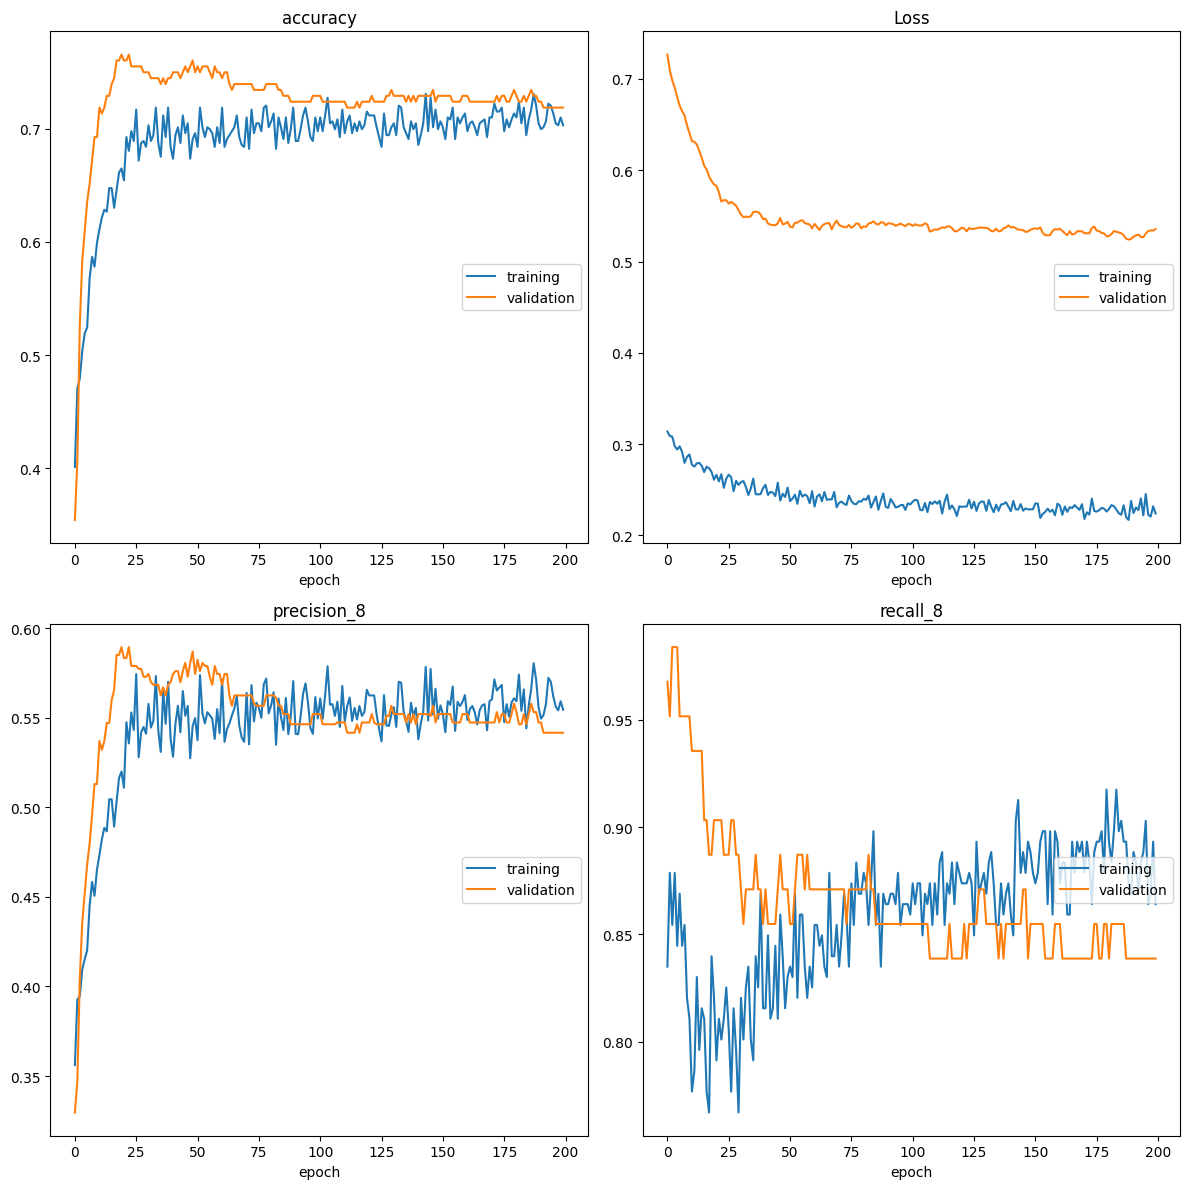

accuracy
	training         	 (min:    0.401, max:    0.731, cur:    0.703)
	validation       	 (min:    0.354, max:    0.766, cur:    0.719)
Loss
	training         	 (min:    0.217, max:    0.314, cur:    0.224)
	validation       	 (min:    0.524, max:    0.727, cur:    0.536)
precision_8
	training         	 (min:    0.356, max:    0.580, cur:    0.555)
	validation       	 (min:    0.330, max:    0.589, cur:    0.542)
recall_8
	training         	 (min:    0.767, max:    0.917, cur:    0.864)
	validation       	 (min:    0.839, max:    0.984, cur:    0.839)
18/18 [==============================] - 1s 49ms/step - loss: 0.2241 - accuracy: 0.7031 - precision_8: 0.5545 - recall_8: 0.8641 - val_loss: 0.5355 - val_accuracy: 0.7188 - val_precision_8: 0.5417 - val_recall_8: 0.8387


In [50]:
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',Precision(),Recall()])

model4.fit(
    x_train_std,
    y_train,
    epochs=200,
    validation_data=(x_test_std,y_test),
    callbacks=[PlotLossesKerasTF()],
    class_weight={1:0.8, 0:0.3}
)

# Dropout also performed better in our metrics

# Applying Models

In [35]:
# How do we actually apply this model to new data?
# First we have to save the model

# h5 file format is a hierarchical data format for multidimensional arrays
model2.save('dbt_model.h5')

In [34]:
# and lets apply the model to new data
import numpy as np

In [37]:
new_data=np.array([[5,120,68,33,0,34.5,0.5,45],[2,80,65,24,0,25,0.20,32]])
new_data

array([[  5. , 120. ,  68. ,  33. ,   0. ,  34.5,   0.5,  45. ],
       [  2. ,  80. ,  65. ,  24. ,   0. ,  25. ,   0.2,  32. ]])

In [38]:
# Load the model you saved
from tensorflow.keras.models import load_model
myModel = load_model('dbt_model.h5')

In [39]:
# scale the new data to what you scaled them before
import joblib
std = joblib.load('StandardScalar_trained.h5') # This was built in the preprocessing function earlier
new_data_std = std.transform(new_data)
new_data_std

/usr/local/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[ 0.33884418, -0.03650431, -0.08865426,  0.74140116, -0.71823753,
         0.28806737,  0.09471934,  0.95195143],
       [-0.53768687, -1.29935622, -0.24658679,  0.17941496, -0.71823753,
        -0.90637429, -0.80861432, -0.13202246]])

In [40]:
myModel.predict(new_data_std)

1/1 [==============================] - 0s 240ms/step


array([[0.9501641 ],
       [0.03471056]], dtype=float32)